## Discovering nonlinear heat equation with temperature dependent thermal conductivity from data using a set of parametric basis functions

In [2]:
# Import required libraried
import numpy as np
import jax.numpy as jnp
import jax
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio

jax.config.update("jax_enable_x64", True)

import PDE_FIND
import optimal_sindy_pde
import importlib
importlib.reload(PDE_FIND)
importlib.reload(optimal_sindy_pde)
from PDE_FIND import build_linear_system, print_pde
from optimal_sindy_pde import OptimalPDESINDy

In [3]:
# Importing the data of nonlinear heat equation

data = sio.loadmat('C:/Users/tabis/Desktop/PhD_second_year/Koopman_gradient_optimization/SINDy_experiments/PDE_FIND/Data/heat_nonlinear_1d_data.mat') # enter the path of the data generated by pde_dataset_generator file
u = real(data['usol'])
x = real(data['x'][0])
t = real(data['t'][0,:])
dt = t[1]-t[0]
dx = x[2]-x[1]

Text(0.5, 0.5, 't')

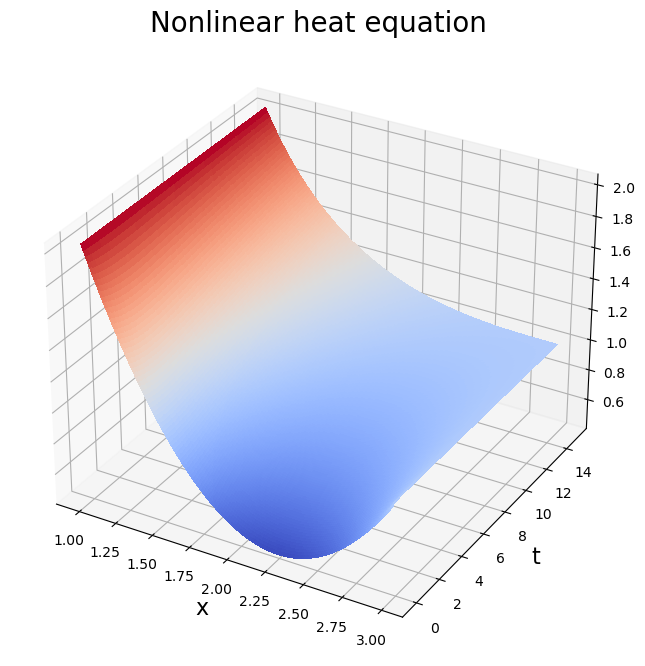

In [4]:
# Plotting the surface

X, T = np.meshgrid(x, t)
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('Nonlinear heat equation', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

In [5]:
# Build the linear system for regression and description of right hand side

Ut, R, rhs_des = build_linear_system(u, dt, dx, D=2, P=2, time_diff = 'FD', space_diff = 'FD')
rhs_des = ['1'] + rhs_des[1:]         # add 1 to the description

In [6]:
# Create a new description including the nonlinear coefficient terms

rhs_des_n = rhs_des.copy()
uxx_ind = rhs_des.index('u_{xx}')
rhs_des_n.append('exp(Xu)u_{x}^2')
rhs_des_n.append('exp(Xu)u_{xx}')
rhs_des_n

['1',
 'u',
 'u^2',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'exp(Xu)u_{x}^2',
 'exp(Xu)u_{xx}']

In [24]:
# initializing the parameters for optimization algorithms

w_init = jnp.zeros((len(rhs_des_n), 1))                      # Initial coefficients vector 
p_init = jnp.array([-0.0])                                    # Initial parameter of the nonlinear term
epss = 1e-2                                                  # Approximation tolerance
loops = 500                                                  # Number of iterations
theta = R                                                    # Data matrix for dictionary 
rhs_des = rhs_des                                            # Description of rhs
Ut = Ut                                                      # Ut column vector
lam = 0                                                      # regularization penalty  


opt_heat_pde = OptimalPDESINDy(epss, loops, rhs_des)

# For step size

D = R.T @ R                                
e = np.linalg.eig(D)                            
L = np.max(e[0])                               
hw = np.real(1/L)
hp = hw
print(hw)

5.905608009658032e-07


## Optimization algorithms implementation

In [25]:
# Adam

w_adam, p_adam, f_vals_adam, f_vals_adam_p = opt_heat_pde.adam_decay(w_init, p_init, theta, Ut, lam, hw=0.1, hp=0.1, decay_rate=1, decay_steps=1)


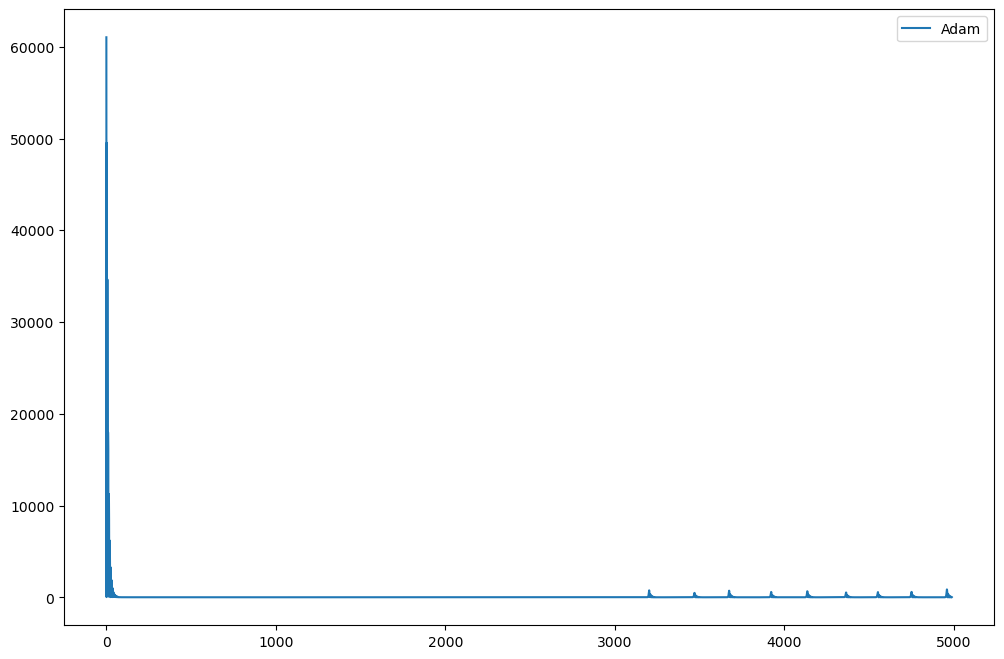

In [26]:
# Plotting the convergence

plt.figure()
plt.plot(f_vals_adam, label='Adam')
plt.legend()

In [27]:
p_adam

Array([-0.9654115], dtype=float64)

In [28]:
w_adam

Array([[ 0.0147899 ],
       [-0.02778602],
       [ 0.00888552],
       [ 0.00135589],
       [ 0.00026583],
       [ 0.00339795],
       [ 0.        ],
       [-0.00205914],
       [-0.00152161],
       [-0.08821328],
       [ 0.08962852]], dtype=float64)

In [29]:
# Print the discovered PDE after doing iterative hard thresholding of values below 0.04 
print_pde(w_adam, rhs_des_n)

u_t = (-0.088213 +0.000000i)exp(Xu)u_{x}^2
    + (0.089629 +0.000000i)exp(Xu)u_{xx}
   


In [30]:
# The value of discovered parameter chi which is p in the code

print(p_adam)

[-0.9654115]


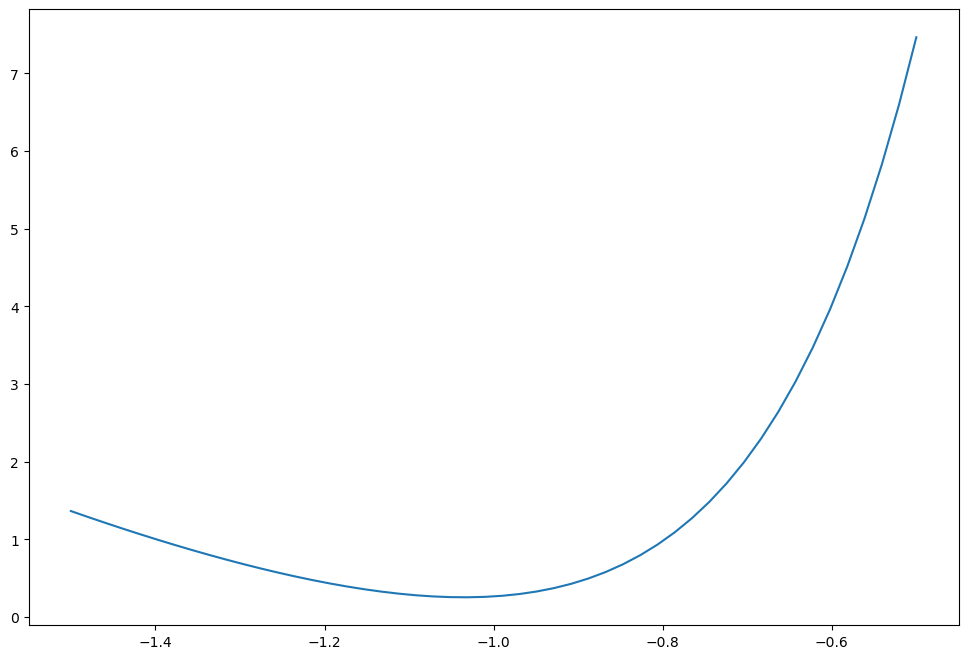

In [32]:
##  Visualizing energy surface

list_chi = np.linspace(-1.5, -0.5, 50)
cost_pde = []

for i in range(len(list_chi)):
    R_n_exp = opt_heat_pde.build_new_theta(list_chi[i], R)
    #w = TrainSTRidge(R_n_exp, Ut, 1e-5, 0.8)
    w_exp = opt_heat_pde.pde_sindy(R_n_exp, Ut, 1e-5, 0.04)
    c = opt_heat_pde.cost_pde_sindy(w_exp, list_chi[i], R, Ut, lam=0)
    cost_pde.append(c) 

# Plot
plt.plot(list_chi, cost_pde)

In [74]:
# Solve with STRidge from PDE_FIND algorithm for different values of parameter p

R_n = opt_heat_pde.build_new_theta(-0.0, R)
w = TrainSTRidge(R_n, Ut, 1e-2, 0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des_n)

C:\Users\tabis\Desktop\PhD_second_year\Koopman_gradient_optimization\SINDy_experiments\PDE_FIND\SINDy_PDE_FIND.py:580: RuntimeWarning: divide by zero encountered in scalar divide
  Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))


LinAlgError: SVD did not converge in Linear Least Squares